In [1]:
!pip install -U -q PyDrive

In [2]:
import sqlite3
import pandas as pd
from pandas.plotting import scatter_matrix
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
!mkdir data

In [5]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [6]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [7]:
df = pd.io.sql.read_sql(
    """
    select avg_diff, pageviews, num_commits
    from
    (
        select uid, avg(cast((julianday(test.checker_ts) - julianday(datetime(deadlines.deadlines, 'unixepoch'))) * 24 as integer)) as avg_diff
        from test left join deadlines on test.labname = deadlines.labs
        where not test.labname = 'project1'
        group by uid
    ) as diff left join
    (
        select uid, count(*) as pageviews
        from pageviews
        group by uid
    ) as views on diff.uid = views.uid left join
    (
        select uid, count(*) as num_commits
        from checker
        group by uid
    ) as commits on diff.uid = commits.uid
    """,
    conn
)

In [8]:
df.head()

,avg_diff,pageviews,num_commits
0,-64.400000,28,84
1,-74.800000,89,137
2,-159.000000,143,259
3,-61.600000,47,62
4,-5.666667,3,66


In [9]:
len(df)

11

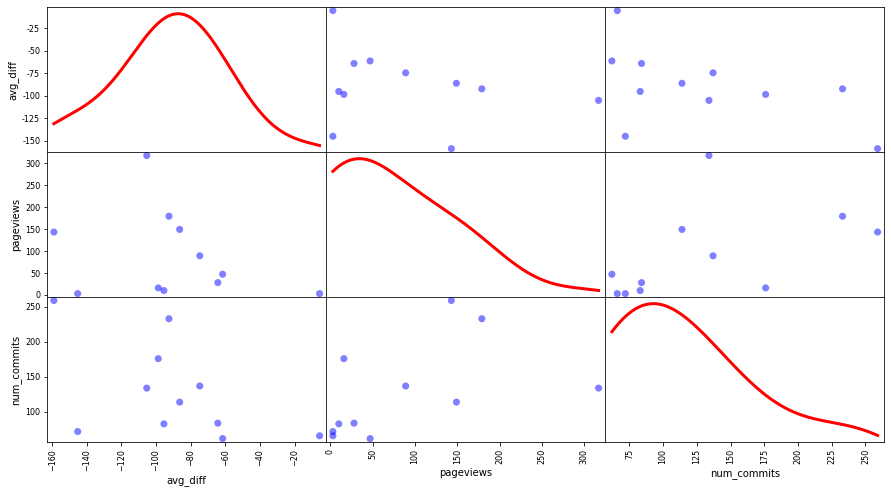

In [14]:
ax = scatter_matrix(df, figsize=(15, 8), diagonal='kde',
                    density_kwds=dict(color='red', linewidth=3),
                    s=200, color='blue')

In [15]:
conn.close()